# Importing libraries and data

In [1]:
import kagglehub
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import matplotlib.pyplot as plt
from lifelines.statistics import multivariate_logrank_test
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report

In [2]:

path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

# Load the dataset into a pandas DataFrame
df = pd.read_csv(path + "/WA_Fn-UseC_-Telco-Customer-Churn.csv")

Path to dataset files: C:\Users\ntlmp\.cache\kagglehub\datasets\blastchar\telco-customer-churn\versions\1


In [3]:
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
df.shape

(7043, 21)

In [5]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

# Data preprocessing

In [6]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')


# Customer Churn Analysis

Questions of Interest:
- How does the churn rate of customers change over time?
- How do the churn rates of different customer groups compare?
    - Male vs. Female
    - Senior Citizen vs. Non-Senior Citizen
- What features are significant in predicting churn status (Cox PH Model)?

Note: `tenure` is the number of months the customer has stayed with the company.


          Customer Survival
timeline                   
0.0                1.000000
1.0                0.945961
2.0                0.927835
3.0                0.913725
4.0                0.901045
...                     ...
68.0               0.626858
69.0               0.620135
70.0               0.609657
71.0               0.602781
72.0               0.592790

[73 rows x 1 columns]
Median Survival Time: inf


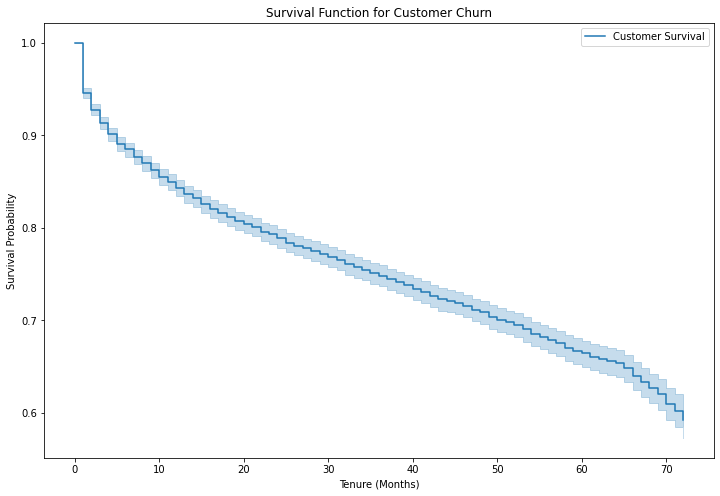

In [7]:

# Prepare variables
tenure = df['tenure']
churn = df['Churn']

# Fit Kaplan-Meier model
kmf = KaplanMeierFitter()
kmf.fit(durations=tenure, event_observed=churn, label='Customer Survival')

# Summary
print(kmf.survival_function_)
print("Median Survival Time:", kmf.median_survival_time_)

# Plot
plt.figure(figsize=(12, 8))
kmf.plot_survival_function(ci_show=True)
plt.xlabel("Tenure (Months)")
plt.ylabel("Survival Probability")
plt.title("Survival Function for Customer Churn")
plt.show()


The survival function plot shows that customer churn probability goes down with longer tenure.

Log-Rank Test p-value: 0.4684
Test Statistic: 0.5257


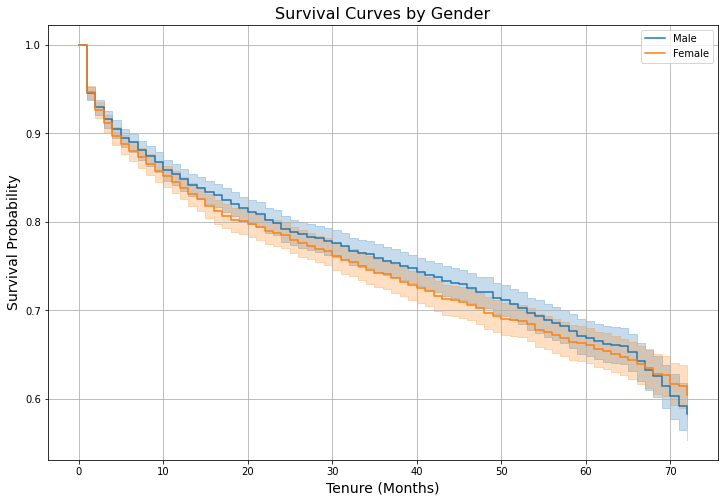

In [8]:
# Separate data by gender
group_male = df[df['gender'] == 'Male']
group_female = df[df['gender'] == 'Female']

# Prepare data for each group
tenure_male = group_male['tenure']
churn_male = group_male['Churn']

tenure_female = group_female['tenure']
churn_female = group_female['Churn']

# Fit Kaplan-Meier models
kmf_male = KaplanMeierFitter()
kmf_female = KaplanMeierFitter()

kmf_male.fit(tenure_male, event_observed=churn_male, label='Male')
kmf_female.fit(tenure_female, event_observed=churn_female, label='Female')

# Plot survival curves together with bigger figure size
plt.figure(figsize=(12, 8))
ax = kmf_male.plot_survival_function(ci_show=True)
kmf_female.plot_survival_function(ax=ax, ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Gender", fontsize=16)
plt.grid(True)

# Log-rank test
results = logrank_test(tenure_male, tenure_female, event_observed_A=churn_male, event_observed_B=churn_female)
print(f"Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

plt.show()

Log-Rank Test p-value: 0.0000
Test Statistic: 109.4897


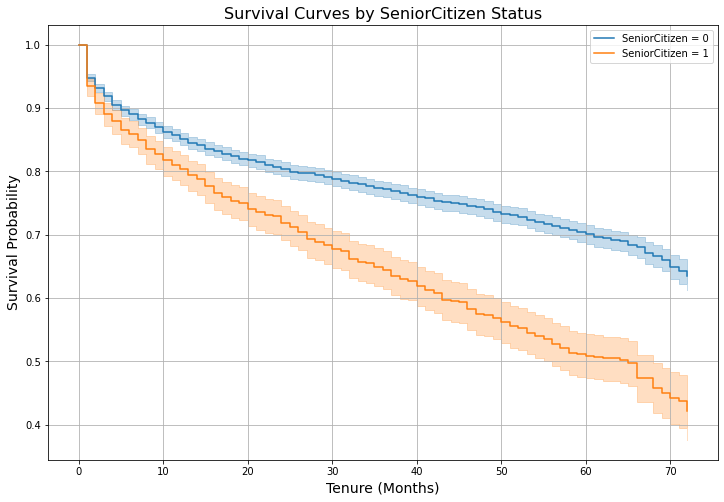

In [9]:


# Separate data by SeniorCitizen group
group_0 = df[df['SeniorCitizen'] == 0]
group_1 = df[df['SeniorCitizen'] == 1]

# Prepare data for each group
tenure_0 = group_0['tenure']
churn_0 = group_0['Churn']

tenure_1 = group_1['tenure']
churn_1 = group_1['Churn']

# Fit Kaplan-Meier models
kmf_0 = KaplanMeierFitter()
kmf_1 = KaplanMeierFitter()

kmf_0.fit(tenure_0, event_observed=churn_0, label='SeniorCitizen = 0')
kmf_1.fit(tenure_1, event_observed=churn_1, label='SeniorCitizen = 1')

# Plot survival curves together with bigger figure size
plt.figure(figsize=(12, 8))
ax = kmf_0.plot_survival_function(ci_show=True)
kmf_1.plot_survival_function(ax=ax, ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by SeniorCitizen Status", fontsize=16)
plt.grid(True)

# Log-rank test
results = logrank_test(tenure_0, tenure_1, event_observed_A=churn_0, event_observed_B=churn_1)
print(f"Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

plt.show()


Log-Rank Test p-value: 0.0000
Test Statistic: 423.5431


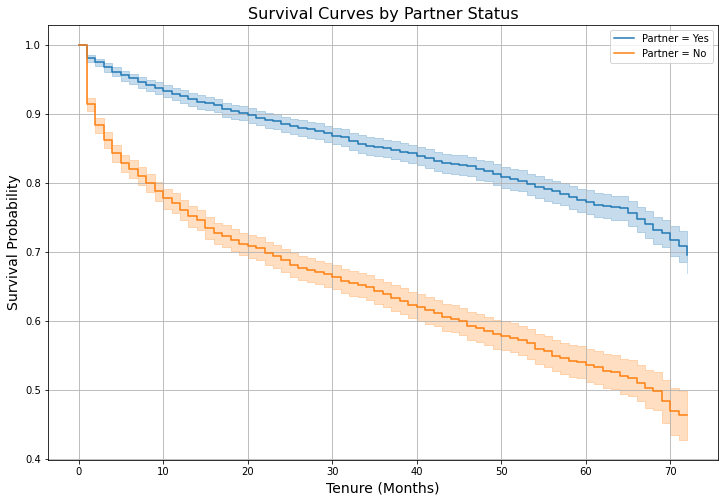

In [10]:
# Separate data by Partner status
group_yes = df[df['Partner'] == 'Yes']
group_no = df[df['Partner'] == 'No']

# Prepare data
tenure_yes = group_yes['tenure']
churn_yes = group_yes['Churn']

tenure_no = group_no['tenure']
churn_no = group_no['Churn']

# Fit Kaplan-Meier models
kmf_yes = KaplanMeierFitter()
kmf_no = KaplanMeierFitter()

kmf_yes.fit(tenure_yes, event_observed=churn_yes, label='Partner = Yes')
kmf_no.fit(tenure_no, event_observed=churn_no, label='Partner = No')

# Plot survival curves bigger figure
plt.figure(figsize=(12, 8))
ax = kmf_yes.plot_survival_function(ci_show=True)
kmf_no.plot_survival_function(ax=ax, ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Partner Status", fontsize=16)
plt.grid(True)

# Log-rank test
results = logrank_test(tenure_yes, tenure_no, event_observed_A=churn_yes, event_observed_B=churn_no)
print(f"Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

plt.show()

Log-Rank Test p-value: 0.0000
Test Statistic: 232.6990


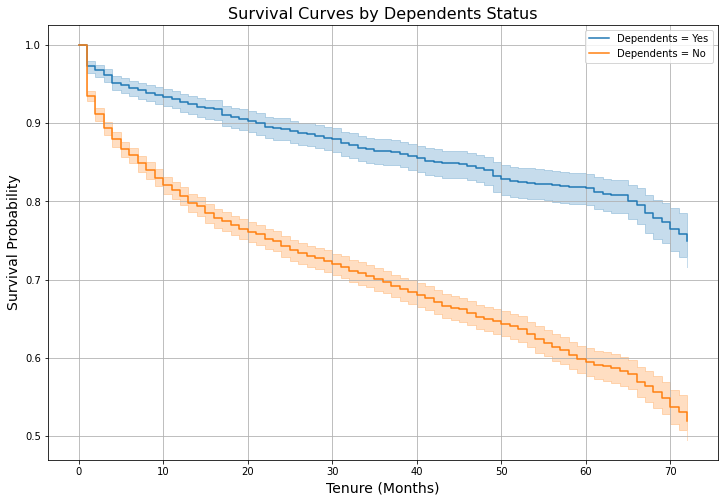

In [11]:
# Separate data by Dependents status
group_yes = df[df['Dependents'] == 'Yes']
group_no = df[df['Dependents'] == 'No']

# Prepare data
tenure_yes = group_yes['tenure']
churn_yes = group_yes['Churn']

tenure_no = group_no['tenure']
churn_no = group_no['Churn']

# Fit Kaplan-Meier models
kmf_yes = KaplanMeierFitter()
kmf_no = KaplanMeierFitter()

kmf_yes.fit(tenure_yes, event_observed=churn_yes, label='Dependents = Yes')
kmf_no.fit(tenure_no, event_observed=churn_no, label='Dependents = No')

# Plot survival curves bigger figure
plt.figure(figsize=(12, 8))
ax = kmf_yes.plot_survival_function(ci_show=True)
kmf_no.plot_survival_function(ax=ax, ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Dependents Status", fontsize=16)
plt.grid(True)

# Log-rank test
results = logrank_test(tenure_yes, tenure_no, event_observed_A=churn_yes, event_observed_B=churn_no)
print(f"Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

plt.show()


Log-Rank Test p-value: 0.5116
Test Statistic: 0.4308


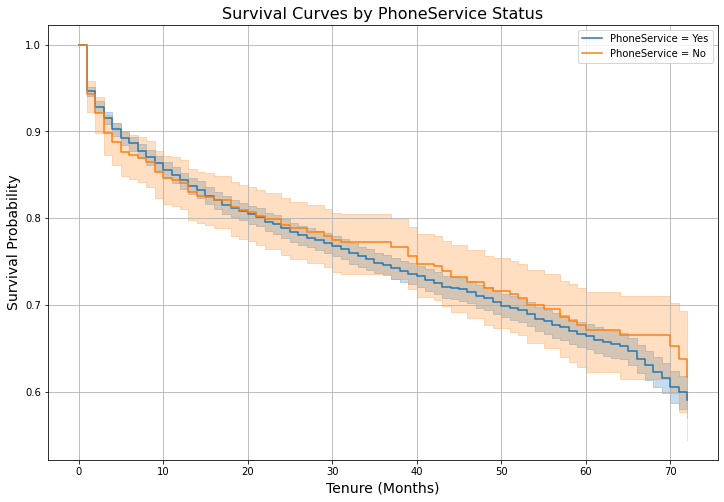

In [12]:
# Separate data by PhoneService status
group_yes = df[df['PhoneService'] == 'Yes']
group_no = df[df['PhoneService'] == 'No']

# Prepare data
tenure_yes = group_yes['tenure']
churn_yes = group_yes['Churn']

tenure_no = group_no['tenure']
churn_no = group_no['Churn']

# Fit Kaplan-Meier models
kmf_yes = KaplanMeierFitter()
kmf_no = KaplanMeierFitter()

kmf_yes.fit(tenure_yes, event_observed=churn_yes, label='PhoneService = Yes')
kmf_no.fit(tenure_no, event_observed=churn_no, label='PhoneService = No')

# Plot survival curves with bigger figure size
plt.figure(figsize=(12, 8))
ax = kmf_yes.plot_survival_function(ci_show=True)
kmf_no.plot_survival_function(ax=ax, ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by PhoneService Status", fontsize=16)
plt.grid(True)

# Log-rank test
results = logrank_test(tenure_yes, tenure_no, event_observed_A=churn_yes, event_observed_B=churn_no)
print(f"Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

plt.show()

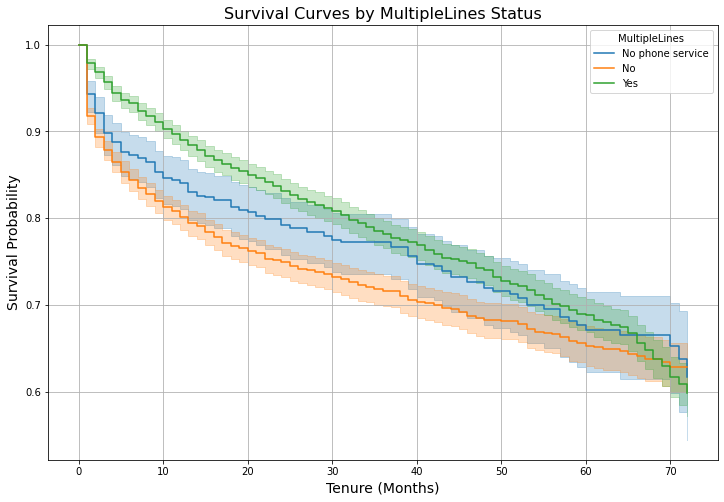

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 30.9690


In [13]:
# Unique categories in MultipleLines
categories = df['MultipleLines'].unique()

plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

for category in categories:
    mask = df['MultipleLines'] == category
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=category)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by MultipleLines Status", fontsize=16)
plt.grid(True)
plt.legend(title='MultipleLines')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['MultipleLines'], event_observed=df['Churn'])
print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

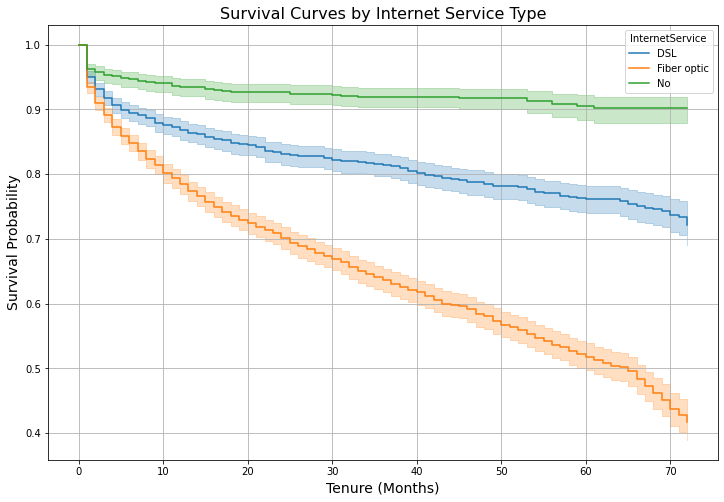

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 520.1206


In [14]:
# Unique categories in InternetService
categories = df['InternetService'].unique()

plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

for category in categories:
    mask = df['InternetService'] == category
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=category)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Internet Service Type", fontsize=16)
plt.grid(True)
plt.legend(title='InternetService')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['InternetService'], event_observed=df['Churn'])
print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

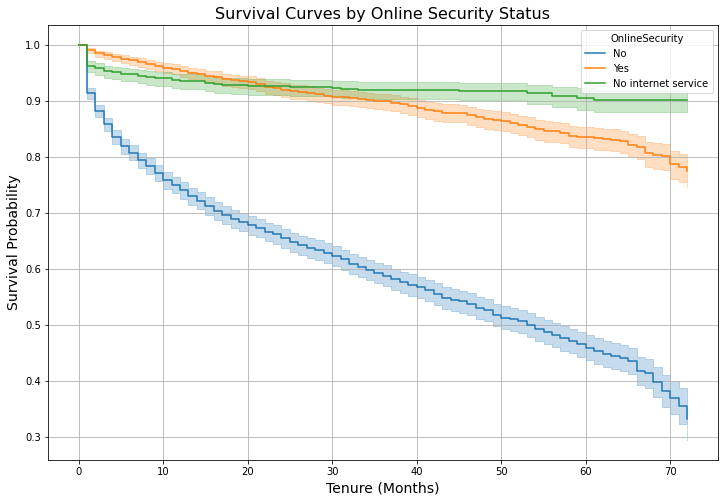

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 1013.8649


In [15]:


# Unique categories in OnlineSecurity
categories = df['OnlineSecurity'].unique()

plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

for category in categories:
    mask = df['OnlineSecurity'] == category
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=category)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Online Security Status", fontsize=16)
plt.grid(True)
plt.legend(title='OnlineSecurity')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['OnlineSecurity'], event_observed=df['Churn'])
print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")


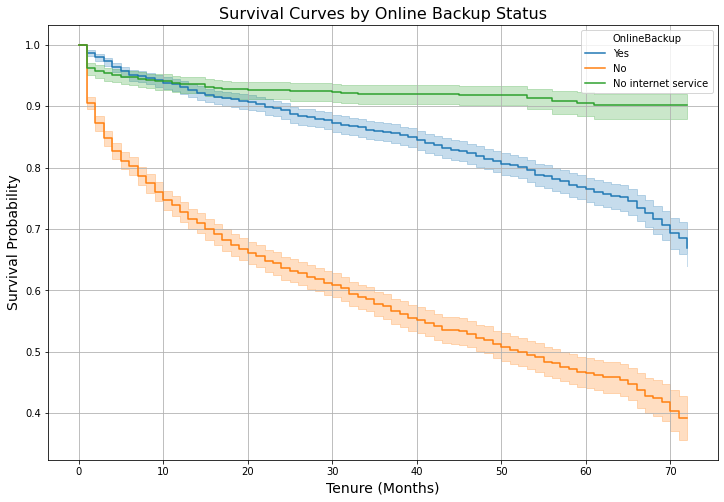

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 821.3388


In [16]:
# Unique categories in OnlineBackup
categories = df['OnlineBackup'].unique()

plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

for category in categories:
    mask = df['OnlineBackup'] == category
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=category)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Online Backup Status", fontsize=16)
plt.grid(True)
plt.legend(title='OnlineBackup')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['OnlineBackup'], event_observed=df['Churn'])
print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

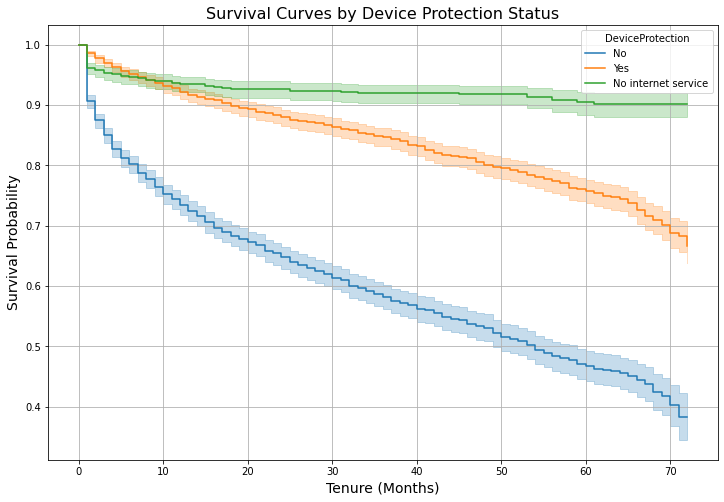

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 763.5064


In [17]:
# Unique categories in DeviceProtection
categories = df['DeviceProtection'].unique()

plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

for category in categories:
    mask = df['DeviceProtection'] == category
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=category)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Device Protection Status", fontsize=16)
plt.grid(True)
plt.legend(title='DeviceProtection')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['DeviceProtection'], event_observed=df['Churn'])
print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

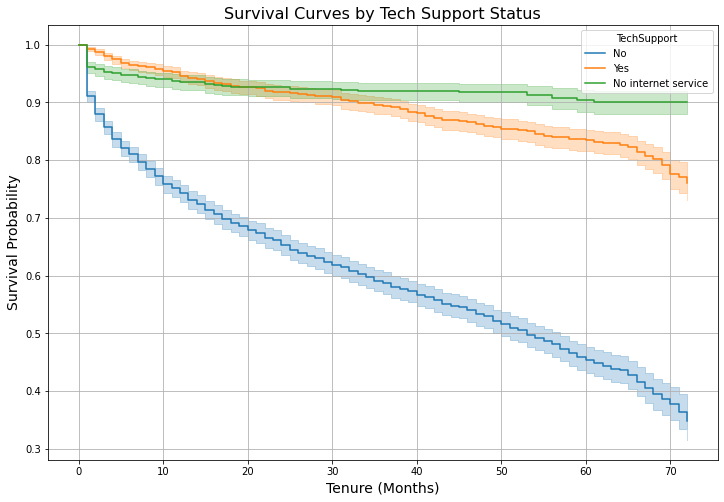

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 989.5601


In [18]:
# Unique categories in TechSupport
categories = df['TechSupport'].unique()

plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

for category in categories:
    mask = df['TechSupport'] == category
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=category)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Tech Support Status", fontsize=16)
plt.grid(True)
plt.legend(title='TechSupport')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['TechSupport'], event_observed=df['Churn'])
print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

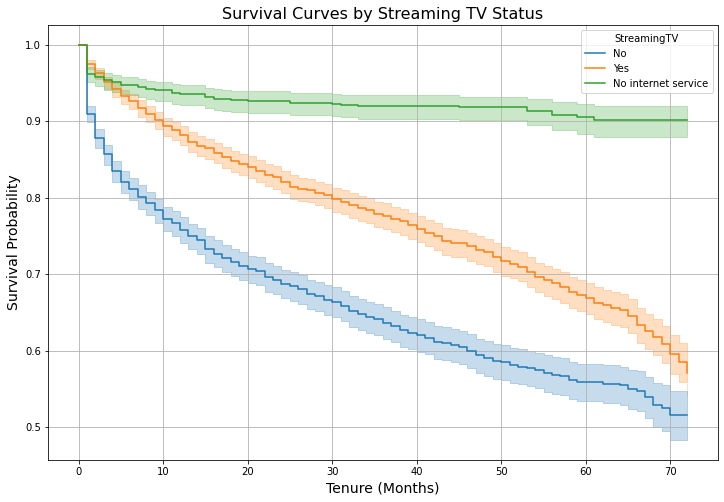

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 368.3074


In [19]:
# Unique categories in StreamingTV
categories = df['StreamingTV'].unique()

plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

for category in categories:
    mask = df['StreamingTV'] == category
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=category)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Streaming TV Status", fontsize=16)
plt.grid(True)
plt.legend(title='StreamingTV')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['StreamingTV'], event_observed=df['Churn'])
print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

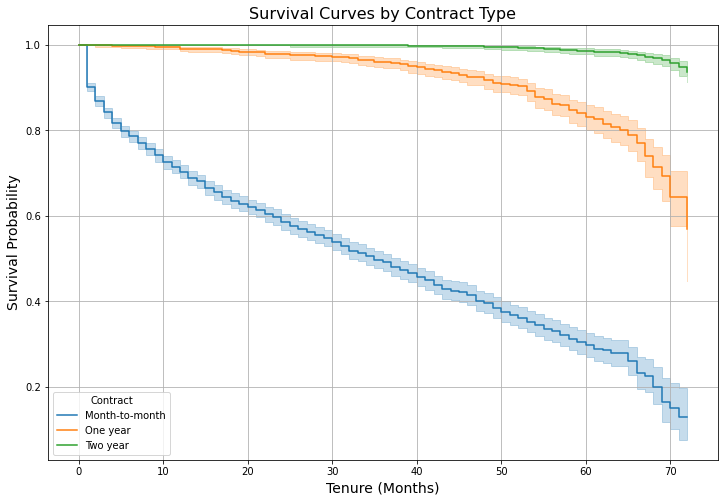

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 2352.8725


In [20]:

# Unique contract types
contract_types = df['Contract'].unique()

# Plot setup
plt.figure(figsize=(12, 8))

kmf = KaplanMeierFitter()

for contract in contract_types:
    mask = df['Contract'] == contract
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=contract)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Contract Type", fontsize=16)
plt.grid(True)
plt.legend(title='Contract')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['Contract'], event_observed=df['Churn'])

print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

Log-Rank Test p-value: 0.0000
Test Statistic: 189.5115


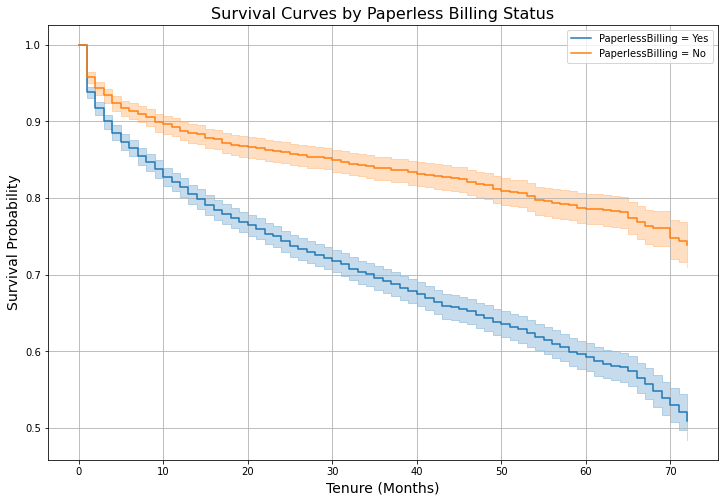

In [21]:
# Separate data by PaperlessBilling status
group_yes = df[df['PaperlessBilling'] == 'Yes']
group_no = df[df['PaperlessBilling'] == 'No']

# Prepare data for each group
tenure_yes = group_yes['tenure']
churn_yes = group_yes['Churn']

tenure_no = group_no['tenure']
churn_no = group_no['Churn']

# Fit Kaplan-Meier models
kmf_yes = KaplanMeierFitter()
kmf_no = KaplanMeierFitter()

kmf_yes.fit(tenure_yes, event_observed=churn_yes, label='PaperlessBilling = Yes')
kmf_no.fit(tenure_no, event_observed=churn_no, label='PaperlessBilling = No')

# Plot survival curves with bigger figure size
plt.figure(figsize=(12, 8))
ax = kmf_yes.plot_survival_function(ci_show=True)
kmf_no.plot_survival_function(ax=ax, ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Paperless Billing Status", fontsize=16)
plt.grid(True)

# Log-rank test
results = logrank_test(tenure_yes, tenure_no, event_observed_A=churn_yes, event_observed_B=churn_no)
print(f"Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

plt.show()

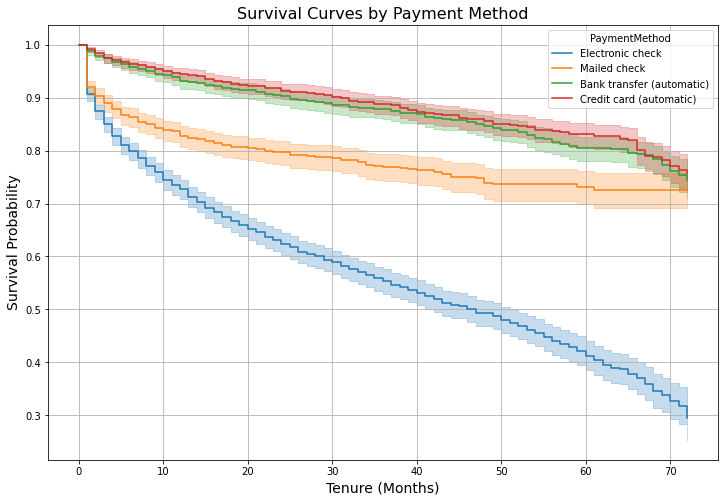

Multigroup Log-Rank Test p-value: 0.0000
Test Statistic: 865.2395


In [22]:
# Unique payment methods
categories = df['PaymentMethod'].unique()

plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

for category in categories:
    mask = df['PaymentMethod'] == category
    kmf.fit(durations=df.loc[mask, 'tenure'], event_observed=df.loc[mask, 'Churn'], label=category)
    kmf.plot_survival_function(ci_show=True)

plt.xlabel("Tenure (Months)", fontsize=14)
plt.ylabel("Survival Probability", fontsize=14)
plt.title("Survival Curves by Payment Method", fontsize=16)
plt.grid(True)
plt.legend(title='PaymentMethod')
plt.show()

# Multigroup log-rank test
results = multivariate_logrank_test(df['tenure'], df['PaymentMethod'], event_observed=df['Churn'])
print(f"Multigroup Log-Rank Test p-value: {results.p_value:.4f}")
print(f"Test Statistic: {results.test_statistic:.4f}")

# Customer Churn Survival Analysis Report
This report summarizes the differences in customer churn patterns across various customer attributes, analyzed using Kaplan–Meier survival curves and log-rank tests to assess statistical significance in churn probabilities.

## Key Findings:
- Gender:
No significant difference in churn rates was observed between male and female customers.

- Senior Citizen Status:
Senior citizens are significantly more likely to churn compared to non-senior customers.

- Partner Status:
Customers without partners exhibit a higher likelihood of churn than those with partners.

- Dependents:
Customers without dependents are more prone to churn than those with dependents.

- Phone Service:
No significant difference in churn was found between customers with or without phone service.

- Multiple Lines:
There was no clear significant difference in churn rates across multiple lines status, though some uncertainty remains.

- Internet Service:
Customers with fiber optic internet service have a significantly higher churn rate compared to those with other internet service types.

- Online Security:
Customers without online security are more likely to churn than those with it.

- Online Backup:
Lack of online backup services is associated with higher churn.

- Device Protection:
Customers without device protection show increased churn rates.

- Tech Support:
Absence of tech support correlates with higher likelihood of churn.

- Streaming TV:
Customers without streaming TV services are more likely to churn, while those with no internet service tend to churn less.

- Contract Type:
Customers on month-to-month contracts have higher churn rates than those with longer-term contracts.

- Paperless Billing:
Customers opting for paperless billing are more likely to churn compared to those who do not.

- Payment Method:
Those using electronic checks exhibit higher churn rates, whereas customers paying via credit card or automatic bank transfer tend to have lower churn.

In [23]:


# List of categorical variables to convert to dummies

categorical_vars = [
    'gender', 'SeniorCitizen', 'PaymentMethod', 'Contract', 'InternetService', 'MultipleLines', 'Dependents', 'Partner'
]

# Copy relevant columns including MonthlyCharges and survival columns
cols_to_use = categorical_vars + ['MonthlyCharges', 'tenure', 'Churn']
data = df[cols_to_use].copy()

# Convert SeniorCitizen to string to treat as categorical (if it is int)
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)

# Convert 'Churn' to binary numeric if needed
if data['Churn'].dtype == 'object':
    data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})

# One-hot encode categorical variables, dropping first category for each to avoid multicollinearity
data_encoded = pd.get_dummies(data, columns=categorical_vars, drop_first=True)

# Check for missing values (optional but recommended)
if data_encoded.isnull().sum().sum() > 0:
    data_encoded = data_encoded.dropna()  # or use imputation if preferred

# Fit Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(data_encoded, duration_col='tenure', event_col='Churn')

# Print the beta coefficients and summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -14006.90
         time fit was run = 2025-08-08 02:28:58 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
MonthlyCharges                        -0.03      0.97      0.00           -0.04           -0.03                0.96                0.97
gender_Male                           -0.07      0.93      0.05           -0.16            0.02                0.85                1.02
SeniorCitizen_1                       -0.03      0.97      0.06           -0.14            0.08                0.87                1.08
PaymentMethod_Credit card (automatic) -0.08      0.93      0.09           -0.25            0.10                0.78                1.11
PaymentMethod_Electronic check         0.68      1.98      0.07            0.54            0.82                1.72                2.27
PaymentMethod_Mailed check             0.57      1.77      0.09            0.40            0.74                1.49                2.10
Contract_One year                     -1.74      0.18      0.09           -1.91           -1.57                0.15                0.21
Contract_Two year                     -3.43      0.03      0.16           -3.75           -3.11                0.02                0.04
InternetService_Fiber optic            1.38      3.99      0.10            1.19            1.58                3.29                4.83
InternetService_No                    -1.53      0.22      0.14           -1.81           -1.24                0.16                0.29
MultipleLines_No phone service        -0.58      0.56      0.11           -0.79           -0.37                0.45                0.69
MultipleLines_Yes                     -0.29      0.75      0.06           -0.40           -0.18                0.67                0.83
Dependents_Yes                        -0.10      0.91      0.07           -0.23            0.04                0.79                1.04
Partner_Yes                           -0.53      0.59      0.06           -0.64           -0.43                0.53                0.65

                                       cmp to      z      p  -log2(p)
covariate                                                            
MonthlyCharges                           0.00 -12.53 <0.005    117.29
gender_Male                              0.00  -1.59   0.11      3.16
SeniorCitizen_1                          0.00  -0.54   0.59      0.77
PaymentMethod_Credit card (automatic)    0.00  -0.84   0.40      1.32
PaymentMethod_Electronic check           0.00   9.62 <0.005     70.38
PaymentMethod_Mailed check               0.00   6.46 <0.005     33.18
Contract_One year                        0.00 -19.86 <0.005    289.22
Contract_Two year                        0.00 -20.97 <0.005    321.94
InternetService_Fiber optic              0.00  14.08 <0.005    147.06
InternetService_No                       0.00 -10.54 <0.005     83.87
MultipleLines_No phone service           0.00  -5.42 <0.005     24.03
MultipleLines_Yes                        0.00  -5.19 <0.005     22.16
Dependents_Yes                           0.00  -1.42   0.16      2.67
Partner_Yes                              0.00  -9.70 <0.005     71.47
---
Concordance = 0.86
Partial AIC = 28041.80
log-likelihood ratio test = 3292.28 on 14 df
-log2(p) of ll-ratio test = inf

In [24]:


# Predict risk scores (partial hazard)
risk_scores = cph.predict_partial_hazard(data_encoded.drop(columns=['tenure', 'Churn']))

# Convert risk_scores to a numpy array
risk_scores = risk_scores.values.flatten()

# Choose threshold (e.g., median risk) to classify churners
threshold = np.median(risk_scores)

# Predict churn = 1 if risk > threshold, else 0
y_pred = (risk_scores > threshold).astype(int)

# Actual churn labels
y_true = data_encoded['Churn'].values

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, risk_scores)  # Use continuous risk scores for ROC AUC

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")


Accuracy:  0.6802
Precision: 0.4456
Recall:    0.8395
F1-score:  0.5822
ROC AUC:   0.7919


# Cox Proportional Hazards Model Summary on Customer Churn
Using a Cox Proportional Hazards model, we analyzed factors influencing customer churn probability. The model included variables such as payment methods, contract types, internet service types, presence of multiple lines, and partnership status.

## Key Findings:

Significant predictors of churn include:

- Payment via electronic check and mailed check.

- Contract types: one-year and two-year contracts.

- Internet service: fiber optic and no internet service.

- Presence of multiple lines.

- Customer partner status.

- Customers on two-year contracts and those with no internet service show a significantly lower risk of churn (i.e., they are more likely to stay subscribed).

- Customers who pay via checks (both electronic and mailed) are more likely to churn compared to those using other payment methods.



# Using fitted model for prediction of new customer

In [25]:
import pandas as pd

# Your sample data as a DataFrame with one row
nate_data = pd.DataFrame({
    'gender': ['Male'],
    'SeniorCitizen': ['0'],  # as string because model expects string categorical
    'PaymentMethod': ['Bank transfer (automatic)'],
    'Contract': ['Month-to-month'],
    'InternetService': ['DSL'],  # assumed
    'MultipleLines': ['No'],
    'Dependents': ['No'],
    'Partner': ['No'],
    'MonthlyCharges': [70],  # assumed
    'tenure': [12]
})

# One-hot encode your profile the same way as training data
nate_encoded = pd.get_dummies(nate_data, columns=categorical_vars, drop_first=True)

# Align columns with the model's training data (data_encoded columns)
# Add missing columns with zeros
for col in data_encoded.columns:
    if col not in nate_encoded.columns:
        nate_encoded[col] = 0

# Keep only the columns the model expects, in the same order
nate_encoded = nate_encoded[data_encoded.columns.drop(['tenure', 'Churn'])]

# Add tenure column for prediction
nate_encoded['tenure'] = 12

# Predict survival probability at 12 months
surv_func = cph.predict_survival_function(nate_encoded, times=[12])
surv_prob = surv_func.loc[12].values[0]
churn_prob = 1 - surv_prob

print(f"Predicted probability of churn by 12 months: {churn_prob:.4f}")


Predicted probability of churn by 12 months: 0.1403


It doesn't look like I'll churn!!

# Deep Learning Approach

In [26]:


categorical_vars = [
    'gender', 'SeniorCitizen', 'PaymentMethod', 'Contract',
    'InternetService', 'MultipleLines', 'Dependents', 'Partner'
]

cols_to_use = categorical_vars + ['MonthlyCharges', 'Churn']
data = df[cols_to_use].copy()

# Encode target
if data['Churn'].dtype == 'object':
    data['Churn'] = data['Churn'].map({'No': 0, 'Yes': 1})

# Convert SeniorCitizen to string for categorical encoding
data['SeniorCitizen'] = data['SeniorCitizen'].astype(str)

# One-hot encode categorical variables
data_encoded = pd.get_dummies(data, columns=categorical_vars)

# Convert bool columns to int
bool_cols = data_encoded.select_dtypes(include=['bool']).columns
data_encoded[bool_cols] = data_encoded[bool_cols].astype(int)

# Separate features and target
X = data_encoded.drop(columns=['Churn'])
y = data_encoded['Churn']

# Scale MonthlyCharges
scaler = StandardScaler()
X['MonthlyCharges'] = scaler.fit_transform(X[['MonthlyCharges']])

# Split into train+val and test first
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X.values, y.values, test_size=0.2, random_state=42, stratify=y)

# Split train+val into train and val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=42, stratify=y_trainval)

# Convert all to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1,1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1,1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1,1)

input_dim = X_train.shape[1]

# Define the model class
class ChurnNet(nn.Module):
    def __init__(self, input_dim, n_units1, n_units2, dropout_rate):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, n_units1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(n_units1, n_units2)
        self.output = nn.Linear(n_units2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

def objective(trial):
    # Suggest hyperparameters
    n_units1 = trial.suggest_int('n_units1', 32, 128)
    n_units2 = trial.suggest_int('n_units2', 16, 64)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epochs = 20

    model = ChurnNet(input_dim, n_units1, n_units2, dropout_rate)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))

        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Validation evaluation
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val).cpu().numpy().flatten()
        y_val_true = y_val.cpu().numpy().flatten()
        auc = roc_auc_score(y_val_true, y_val_pred)

    return auc

# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best hyperparameters:", study.best_params)
print(f"Best validation ROC AUC: {study.best_value:.4f}")

# Train final model with best hyperparameters on train+val data
best_params = study.best_params
final_model = ChurnNet(input_dim,
                      best_params['n_units1'],
                      best_params['n_units2'],
                      best_params['dropout_rate'])
criterion = nn.BCELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

# Combine train and val data for final training
X_trainval = torch.tensor(X_trainval, dtype=torch.float32)
y_trainval = torch.tensor(y_trainval, dtype=torch.float32).view(-1,1)

batch_size = best_params['batch_size']
epochs = 30

for epoch in range(epochs):
    final_model.train()
    permutation = torch.randperm(X_trainval.size(0))

    for i in range(0, X_trainval.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_trainval[indices], y_trainval[indices]

        optimizer.zero_grad()
        outputs = final_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# Evaluate on test set
final_model.eval()
with torch.no_grad():
    y_test_pred = final_model(X_test).cpu().numpy().flatten()
    y_test_true = y_test.cpu().numpy().flatten()
    y_test_pred_label = (y_test_pred > 0.5).astype(int)

print("Test Set Performance:")
print(classification_report(y_test_true, y_test_pred_label))
print("Test ROC AUC:", roc_auc_score(y_test_true, y_test_pred))



[I 2025-08-07 19:28:59,443] A new study created in memory with name: no-name-588178be-c444-4f5b-bdb6-09618fb1e61a
[I 2025-08-07 19:29:03,538] Trial 0 finished with value: 0.8213893332040781 and parameters: {'n_units1': 83, 'n_units2': 27, 'dropout_rate': 0.1865553576388951, 'learning_rate': 0.0002467799882682711, 'batch_size': 128}. Best is trial 0 with value: 0.8213893332040781.
[I 2025-08-07 19:29:08,424] Trial 1 finished with value: 0.8217205499814195 and parameters: {'n_units1': 88, 'n_units2': 44, 'dropout_rate': 0.21543740719771992, 'learning_rate': 0.00013790107655367484, 'batch_size': 32}. Best is trial 1 with value: 0.8217205499814195.
[I 2025-08-07 19:29:13,979] Trial 2 finished with value: 0.8213610586011342 and parameters: {'n_units1': 117, 'n_units2': 35, 'dropout_rate': 0.3813787619479768, 'learning_rate': 0.00011137952837174767, 'batch_size': 32}. Best is trial 1 with value: 0.8217205499814195.
[I 2025-08-07 19:29:15,427] Trial 3 finished with value: 0.815338568174107 an

Best hyperparameters: {'n_units1': 78, 'n_units2': 45, 'dropout_rate': 0.18697850249693845, 'learning_rate': 0.0001028598839795539, 'batch_size': 64}
Best validation ROC AUC: 0.8238
Test Set Performance:
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84      1035
         1.0       0.57      0.46      0.51       374

    accuracy                           0.76      1409
   macro avg       0.69      0.67      0.68      1409
weighted avg       0.75      0.76      0.75      1409

Test ROC AUC: 0.8097806711617452


# Conclusion

This churn prediction project demonstrates skills that bridge both A/B testing and product analyst responsibilities.

From an A/B testing perspective, the use of Kaplan-Meier survival curves and log-rank tests parallels how experimenters evaluate differences between treatment and control groups over time. These statistical methods help assess whether interventions (such as changes in pricing plans, contract options, or marketing offers) significantly impact customer retention or churn rates. The ability to rigorously test and interpret time-to-event outcomes is critical for making data-driven decisions about product features or customer engagement strategies.

On the product analyst side, building and optimizing a neural network for churn prediction showcases strong capabilities in feature engineering, predictive modeling, and extracting actionable insights from complex customer data. Product analysts often need to understand user behavior patterns, segment customers, and forecast outcomes to prioritize product improvements and tailor user experiences. The enhanced predictive accuracy from the neural network model enables precise identification of high-risk customers, facilitating targeted retention campaigns and personalized product offerings.

Together, these approaches reflect a comprehensive analytical skill set: designing and analyzing controlled experiments (A/B testing) to measure impact, alongside developing advanced predictive models (product analytics) to inform strategic decisions. Mastery of both areas positions you well to drive product growth and customer engagement in data-centric roles.

# Model Discussion
The neural network model, optimized via hyperparameter tuning, achieved a higher overall accuracy of 76% and a better ROC AUC of 0.808, indicating strong discriminative ability between churners and non-churners. It showed particularly high precision and balanced performance across both classes, though recall for churners was moderate at 45%.

In contrast, the Cox Proportional Hazards model yielded a lower accuracy of 68% and a ROC AUC of 0.792, but demonstrated a much higher recall of 84% for churners, suggesting it is more sensitive in identifying customers likely to churn. However, this came at the cost of lower precision (around 45%), meaning more false positives.

These results highlight a trade-off between the two approaches: the neural network excels at overall classification accuracy and precision, while the Cox PH model prioritizes recall, making it effective for catching most churners but with more false alarms. Depending on business priorities — minimizing missed churners (high recall) vs. reducing false retention efforts (high precision) — either model could be preferred or they could be combined in an ensemble.